In [2]:
# HIDDEN
import matplotlib
#matplotlib.use('Agg')
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plots.style.use('fivethirtyeight')

In [3]:
# HIDDEN

def standard_units(x):
    return (x - np.mean(x))/np.std(x)

### Rows of Tables ###
Now that we have a qualitative understanding of nearest neighbor classification, it's time to implement our classifier. As a first step, note that until this chapter we have worked mostly with variables – that is, columns of tables. But now we have to see whether one *individual* is "close" to another. Data for individuals are contained in *rows* of tables.

So let's start by taking a closer look at rows.

Here is the original table `ckd` containing data on patients who were tested for chronic kidney disease.

In [4]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')

The data corresponding to the first patient is in Row 0 of the table, consistent with Python's indexing system. The Table method `row` accesses the row by taking the index of the row as its argument:

In [5]:
ckd.row(0)

Row(Age=48, Blood Pressure=70, Specific Gravity=1.0049999999999999, Albumin=4, Sugar=0, Red Blood Cells='normal', Pus Cell='abnormal', Pus Cell clumps='present', Bacteria='notpresent', Glucose=117, Blood Urea=56, Serum Creatinine=3.7999999999999998, Sodium=111, Potassium=2.5, Hemoglobin=11.199999999999999, Packed Cell Volume=32, White Blood Cell Count=6700, Red Blood Cell Count=3.8999999999999999, Hypertension='yes', Diabetes Mellitus='no', Coronary Artery Disease='no', Appetite='poor', Pedal Edema='yes', Anemia='yes', Class=1)

Rows have their very own data type: they are *row objects*. Notice how the display shows not only the values in the row but also the labels of the corresponding columns.

Rows are in general **not arrays**, as their elements can be of different types. For example, some of the elements of the row above are categorical and some are numerical. So the row can't be converted into an array.

However, you can use `item` as with arrays, to access a particular element of the row. For example, to access the Albumin level of Patient 0, you just have to look at the column labels and note that it's item 3 of the row:

In [6]:
ckd.row(0).item(3)

4

### Converting Rows to Arrays (When Possible) ###
Rows don't necessarily consist only of one type of element, so usually they can't be convereted to arrays. But rows that are entirely numerical can be converted to arrays. This makes it easier to work with them.

Recall that in the previous section we tried to classify the patients as 'CKD' or 'not CKD', based on two attributes `Hemoglobin` and `Glucose`, both measured in standard units. 

In [7]:
ckd = Table().with_columns(
    'Hemoglobin', standard_units(ckd.column('Hemoglobin')),
    'Glucose', standard_units(ckd.column('Glucose')),
    'Class', ckd.column('Class')
)

color_table = Table().with_columns(
    'Class', make_array(1, 0),
    'Color', make_array('darkblue', 'gold')
)
ckd = ckd.join('Class', color_table)
ckd

Class,Hemoglobin,Glucose,Color
0,0.456884,0.133751,gold
0,1.153,-0.947597,gold
0,0.770138,-0.762223,gold
0,0.596108,-0.190654,gold
0,-0.239236,-0.49961,gold
0,-0.0304002,-0.159758,gold
0,0.282854,-0.00527964,gold
0,0.108824,-0.623193,gold
0,0.0740178,-0.515058,gold
0,0.83975,-0.422371,gold


Here is a scatter plot of the two attributes, along with a red point corresponding to Alice, a new patient. Her value of hemoglobin is 0 (that is, at the average) and glucose 1.1 (that is, 1.1 SDs above average).

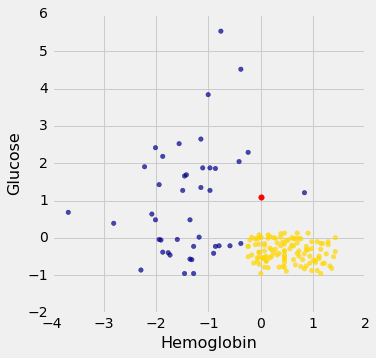

In [8]:
alice = make_array(0, 1.1)
ckd.scatter('Hemoglobin', 'Glucose', colors='Color')
plots.scatter(alice.item(0), alice.item(1), color='red', s=30);

To find the distance between Alice's point and any of the other points, we only need the values of the attributes:

In [9]:
ckd_attributes = ckd.select('Hemoglobin', 'Glucose')

In [10]:
ckd_attributes

Hemoglobin,Glucose
0.456884,0.133751
1.153,-0.947597
0.770138,-0.762223
0.596108,-0.190654
-0.239236,-0.49961
-0.0304002,-0.159758
0.282854,-0.00527964
0.108824,-0.623193
0.0740178,-0.515058
0.83975,-0.422371


Each row consists of the coordinates of one point in our training sample. **Because the rows now consist only of numerical values**, it is possible to convert them to arrays using the function `np.array`. Our old friend `make_array` doesn't work on rows.

In [11]:
ckd_attributes.row(3)

Row(Hemoglobin=0.59610766482326683, Glucose=-0.19065363034327712)

In [12]:
np.array(ckd_attributes.row(3))

array([ 0.59610766, -0.19065363])

This is very handy because we can now use array operations on the data in each row.

### Distance Between Points When There are Two Attributes ###
The main calculation we need to do is to find the distance between Alice's point and any other point. For this, the first thing we need is a way to compute the distance between any pair of points. 

How do we do this?  In 2-dimensional space, it's pretty easy.  If we have a point at coordinates $(x_0,y_0)$ and another at $(x_1,y_1)$, the distance between them is

$$
D = \sqrt{(x_0-x_1)^2 + (y_0-y_1)^2}
$$

(Where did this come from?  It comes from the Pythogorean theorem: we have a right triangle with side lengths $x_0-x_1$ and $y_0-y_1$, and we want to find the length of the hypotenuse.)



In the next section we'll see that this formula has a straightforward extension when there are more than two attributes. For now, let's use the formula and array operations to find the distance between Alice and the patient in Row 3.

In [13]:
patient3 = np.array(ckd_attributes.row(3))
alice, patient3

(array([ 0. ,  1.1]), array([ 0.59610766, -0.19065363]))

In [14]:
distance = np.sqrt(np.sum((alice - patient3)**2))
distance

1.4216649188818471

We're going to need the distance between Alice and a bunch of points, so let's write a function called `distance` that computes the distance between any pair of points. The function will take two arrays, corresponding to the $(x, y)$ coordinates of each point.

In [15]:
def distance(point1, point2):
    """Returns the Euclidean distance between point1 and point2
    where each argument is an array consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

In [16]:
distance(alice, patient3)

1.4216649188818471

We have begun to build our classifier: the `distance` function is the first building block. Now let's work on the next piece.

### Using `apply` on an Entire Row ###
Recall that if you want to apply a function to each element of a column of a table, one way to do that is by the call `table_name.apply(function_name, column_label)`. This evaluates to an array consisting of the values of the function for all the elements of the column. So each entry of the array is based on the corresponding row of the table.

If you use `apply` without specifying a column label, then the entire row is passed to the function. Let's see how this works on a very small table `t` corresponding to the first five patients in the training sample.

In [17]:
t = ckd_attributes.take(np.arange(5))
t

Hemoglobin,Glucose
0.456884,0.133751
1.153,-0.947597
0.770138,-0.762223
0.596108,-0.190654
-0.239236,-0.49961


Just as an example, suppose that for each patient we want to know which one is further away from average: the hemoglobin level or the glucose level. In other words, we want to know which of `hemoglobin` and `glucose` is further away from 0, because each is measured in standard untits. 

That's the same as taking the maximum of the absolute values of the two quantities. To do this for a particular row, we can convert the row to an array and use array operations.

In [18]:
def max_abs(row):
    return np.max(np.abs(np.array(row)))

In [19]:
max_abs(t.row(4))

0.49961028259186968

And now we can apply `max_abs` to each row of the table `t`:

In [20]:
t.apply(max_abs)

array([ 0.4568837 ,  1.15300352,  0.77013762,  0.59610766,  0.49961028])

This way of using `apply` will help us create the next building block of our classifier.

### Alice's $k$ Nearest Neighbors ###
If we want to classify Alice using a k-nearest neighbor classifier, we have to identify her $k$ nearest neighbors. What are the steps in this process? Suppose $k = 5$. Then the steps are:
- **Step 1.** Find the distance between Alice and each point in the training sample.
- **Step 2.** Sort the data table in increasing order of the distances.
- **Step 3.** Take the top 5 rows of the sorted table.

Steps 2 and 3 seem straightforward, provided we have the distances. So let's focus on Step 1.

Here's Alice:

In [21]:
alice

array([ 0. ,  1.1])

What we need is a function that finds the distance between Alice and another point whose coordinates are contained in a row. The function `distance` returns the distance between any two points whose coordinates are in arrays. We can use that to define `distance_from_alice`, which takes a row as its argument and returns the distance between that row and Alice.

In [22]:
def distance_from_alice(row):
    """Returns distance between Alice and a row of the attributes table"""
    return distance(alice, np.array(row))

In [23]:
distance_from_alice(ckd_attributes.row(3))

1.4216649188818471

Now we can `apply` the function `distance_from_alice` to each row of `ckd_attributes`, and augment the table `ckd` with the distances. Step 1 is complete!

In [24]:
distances = ckd_attributes.apply(distance_from_alice)
ckd_with_distances = ckd.with_column('Distance from Alice', distances)

In [25]:
ckd_with_distances

Class,Hemoglobin,Glucose,Color,Distance from Alice
0,0.456884,0.133751,gold,1.06882
0,1.153,-0.947597,gold,2.34991
0,0.770138,-0.762223,gold,2.01519
0,0.596108,-0.190654,gold,1.42166
0,-0.239236,-0.49961,gold,1.6174
0,-0.0304002,-0.159758,gold,1.26012
0,0.282854,-0.00527964,gold,1.1409
0,0.108824,-0.623193,gold,1.72663
0,0.0740178,-0.515058,gold,1.61675
0,0.83975,-0.422371,gold,1.73862


For Step 2, let's sort the table in increasing order of distance:

In [26]:
sorted_by_distance = ckd_with_distances.sort('Distance from Alice')
sorted_by_distance

Class,Hemoglobin,Glucose,Color,Distance from Alice
1,0.83975,1.2151,darkblue,0.847601
1,-0.970162,1.27689,darkblue,0.986156
0,-0.0304002,0.0874074,gold,1.01305
0,0.14363,0.0874074,gold,1.02273
1,-0.413266,2.04928,darkblue,1.03534
0,0.387272,0.118303,gold,1.05532
0,0.456884,0.133751,gold,1.06882
0,0.178436,0.0410639,gold,1.07386
0,0.00440582,0.025616,gold,1.07439
0,-0.169624,0.025616,gold,1.08769


Step 3: The top 5 rows correspond to Alice's 5 nearest neighbors; you can replace 5 by any other positive integer.

In [27]:
alice_5_nearest_neighbors = sorted_by_distance.take(np.arange(5))
alice_5_nearest_neighbors

Class,Hemoglobin,Glucose,Color,Distance from Alice
1,0.83975,1.2151,darkblue,0.847601
1,-0.970162,1.27689,darkblue,0.986156
0,-0.0304002,0.0874074,gold,1.01305
0,0.14363,0.0874074,gold,1.02273
1,-0.413266,2.04928,darkblue,1.03534


Three of Alice's five nearest neighbors are blue points and two are gold. So a 5-nearest neighbor classifier would classify Alice as blue: it would predict that Alice has chronic kidney disease.

The graph below zooms in on Alice and her five nearest neighbors. The two gold ones just inside the circle directly below the red point. The classifier says Alice is more like the three blue ones around her.

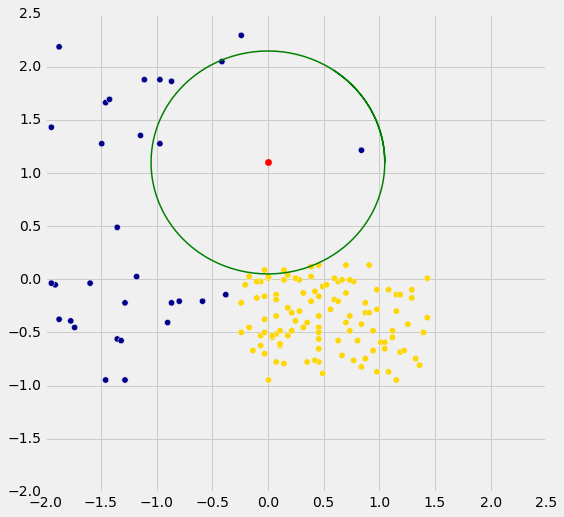

In [28]:
# HIDDEN
plots.figure(figsize=(8,8))
plots.scatter(ckd.column('Hemoglobin'), ckd.column('Glucose'), c=ckd.column('Color'), s=40)
#ckd.scatter('Hemoglobin', 'Glucose', colors='Color')
plots.scatter(alice.item(0), alice.item(1), color='red', s=40)
radius = sorted_by_distance.column('Distance from Alice').item(4)+0.014
theta = np.arange(0, 2*np.pi+1, 2*np.pi/200)
plots.plot(radius*np.cos(theta)+alice.item(0), radius*np.sin(theta)+alice.item(1), color='g', lw=1.5);
plots.xlim(-2, 2.5)
plots.ylim(-2, 2.5);

We are well on our way to implementing our k-nearest neighbor classifier. In the next two sections we will put it together and assess its accuracy.